# CGANs - Conditional Generative Adversarial Nets

Brief introduction to Conditional Generative Adversarial Nets or CGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training CGANs with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 3. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

* **Generator**: The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

* **Discriminator**: $x$ and $y$ are presented as inputs and to a discriminative function.

### Network Design

<img src="../../img/network_design_ccgan.png" width="600"> 


### Cost Funcion

$$ \underset{G}{min} \: \underset{D}{max} \; V_{CGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$


## 4. Training CGANs with MNIST dataset, Keras and TensorFlow

CGANs implementation using fully connected and embedding layers and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * **Simple fully connected neural network**, **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator are the **normal distribution** $z$ and $y$. They are combined in joint hidden representation.
        * Embedding($y, z$).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Simple fully connected neural network** and **LeakyReLU activation**.
    * The input to the discriminator are $x$ and $y$. They are combined in joint hidden representation.
        *  Embedding($y, x$).
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


2023-11-01 15:30:23.411612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 15:30:23.444141: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


---
#### Embedding layer background

1/1 [==============================] - 0s 33ms/step
[[[ 0.00074769  0.00742732]
  [ 0.04362575 -0.045568  ]
  [-0.02783407 -0.00706906]
  [-0.01229655  0.00325335]
  [-0.02115539  0.03527499]
  [-0.03752016  0.02964555]
  [ 0.01323736 -0.04773157]
  [-0.0011031  -0.01890194]
  [ 0.02555425 -0.04788982]
  [ 0.03714799  0.02510751]]]


2023-11-01 15:30:24.121944: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-01 15:30:24.121961: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: vector
2023-11-01 15:30:24.121964: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: vector
2023-11-01 15:30:24.122025: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.113.1
2023-11-01 15:30:24.122034: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.5
2023-11-01 15:30:24.122037: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 535.104.5 does not match DSO version 535.113.1 -- cannot find working devices in this configuration
2023-11-01 15:30:24.123039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow

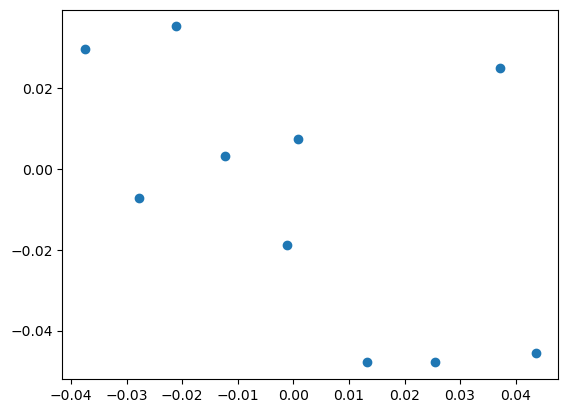

In [2]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 
# 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])


---
#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


#### Explore visual data

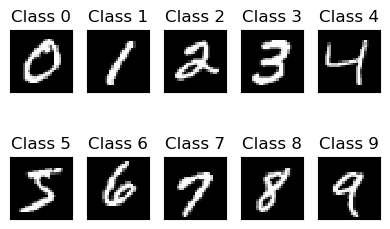

In [4]:
WIDTH_SIZE = 4
HEIGHT_SIZE = 3

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()


#### Reshaping and normalizing the inputs

In [5]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)


X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_train reshape: (60000, 784)


### 2. Define model

#### Generator

In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

seed_value = 42
initializer = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02, seed=seed_value
)


# Generator network
generator = tf.keras.models.Sequential()

# Input layer and hidden layer 1
generator.add(
    tf.keras.layers.Dense(
        128, input_shape=(latent_dim,), kernel_initializer=initializer
    )
)
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(tf.keras.layers.Dense(256))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(tf.keras.layers.Dense(512))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))

# Output layer
generator.add(tf.keras.layers.Dense(img_dim, activation="tanh"))


#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                      

#### Conditional G model
The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation.

In [8]:
# Embedding condition in input layer
num_classes = 10

# Create label embeddings
label = tf.keras.layers.Input(shape=(1,), dtype='int32')
label_embedding = tf.keras.layers.Embedding(num_classes, latent_dim)(label)
label_embedding = tf.keras.layers.Flatten()(label_embedding)

# latent space
z = tf.keras.layers.Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = tf.keras.layers.multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = tf.keras.models.Model([z, label], img)


#### Conditional model visualization

In [9]:
# prints a summary representation of your model
generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       1000        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 100)          0           ['embedding_1[0][0]']            
                                                                                              

#### Discriminator

In [10]:
# Discriminator network
discriminator = tf.keras.models.Sequential()

# Input layer and hidden layer 1
discriminator.add(
    tf.keras.layers.Dense(
        128, input_shape=(img_dim,), kernel_initializer=initializer
    )
)
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(tf.keras.layers.Dense(256))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(tf.keras.layers.Dense(512))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(tf.keras.layers.Dense(1, activation="sigmoid"))


#### Discriminator model visualization

In [11]:
# prints a summary representation of your model
discriminator.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

#### Conditional D model

$x$ and $y$ are presented as inputs

In [12]:
# Embedding condition in input layer

# Create label embeddings
label_d = tf.keras.layers.Input(shape=(1,), dtype='int32')
label_embedding_d = tf.keras.layers.Embedding(num_classes, img_dim)(label_d)
label_embedding_d = tf.keras.layers.Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = tf.keras.layers.Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = tf.keras.layers.multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = tf.keras.models.Model([img_d, label_d], validity)


#### Conditional model visualization

In [13]:
# prints a summary representation of your model
discriminator.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 784)       7840        ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['embedding_2[0][0]']            
                                                                                            

### 3. Compile model

#### Compile discriminator

In [14]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)


#### Combined network

In [15]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = tf.keras.models.Model([z, label], validity)

d_g.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)


In [16]:
# prints a summary representation of your model
d_g.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 784)          584312      ['input_2[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            273441      ['model[0][0]',            

### 4. Fit model


epoch = 1/100, d_loss=0.672, g_loss=0.962                                                                                                                      
1/1 [==============================] - 0s 42ms/step


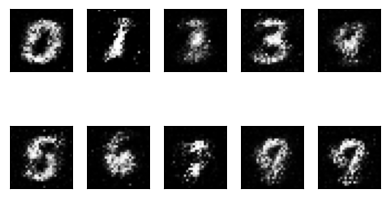

epoch = 2/100, d_loss=0.684, g_loss=0.831                                                                                                                      
epoch = 3/100, d_loss=0.670, g_loss=0.864                                                                                                                      
epoch = 4/100, d_loss=0.700, g_loss=0.826                                                                                                                      
epoch = 5/100, d_loss=0.680, g_loss=0.811                                                                                                                      
epoch = 6/100, d_loss=0.676, g_loss=0.806                                                                                                                      
epoch = 7/100, d_loss=0.673, g_loss=0.822                                                                                                                      
epoch = 8/100, d_loss=0.676, g_loss=0.84

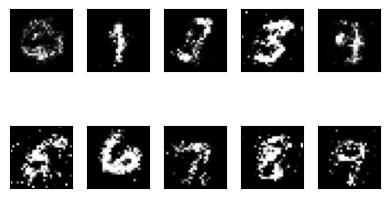

epoch = 12/100, d_loss=0.635, g_loss=0.860                                                                                                                      
epoch = 13/100, d_loss=0.609, g_loss=0.883                                                                                                                      
epoch = 14/100, d_loss=0.667, g_loss=0.816                                                                                                                      
epoch = 15/100, d_loss=0.655, g_loss=0.936                                                                                                                      
epoch = 16/100, d_loss=0.614, g_loss=0.991                                                                                                                      
epoch = 17/100, d_loss=0.677, g_loss=0.949                                                                                                                      
epoch = 18/100, d_loss=0.685, g_lo

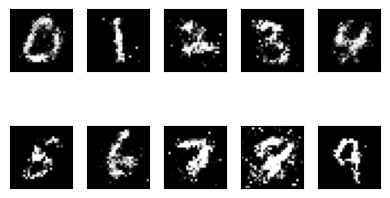

epoch = 22/100, d_loss=0.666, g_loss=0.909                                                                                                                      
epoch = 23/100, d_loss=0.668, g_loss=0.860                                                                                                                      
epoch = 24/100, d_loss=0.649, g_loss=0.913                                                                                                                      
epoch = 25/100, d_loss=0.667, g_loss=0.917                                                                                                                      
epoch = 26/100, d_loss=0.651, g_loss=0.876                                                                                                                      
epoch = 27/100, d_loss=0.635, g_loss=0.864                                                                                                                      
epoch = 28/100, d_loss=0.631, g_lo

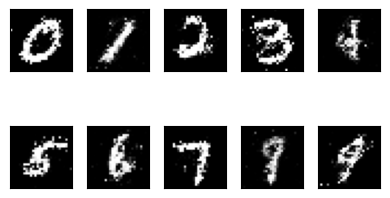

epoch = 32/100, d_loss=0.657, g_loss=0.964                                                                                                                      
epoch = 33/100, d_loss=0.641, g_loss=0.874                                                                                                                      
epoch = 34/100, d_loss=0.634, g_loss=0.871                                                                                                                      
epoch = 35/100, d_loss=0.651, g_loss=0.921                                                                                                                      
epoch = 36/100, d_loss=0.636, g_loss=0.939                                                                                                                      
epoch = 37/100, d_loss=0.618, g_loss=0.942                                                                                                                      
epoch = 38/100, d_loss=0.653, g_lo

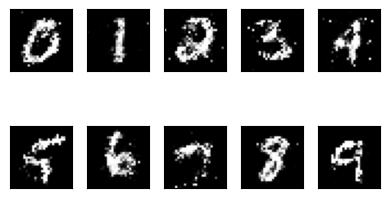

epoch = 42/100, d_loss=0.666, g_loss=0.908                                                                                                                      
epoch = 43/100, d_loss=0.629, g_loss=0.893                                                                                                                      
epoch = 44/100, d_loss=0.636, g_loss=0.835                                                                                                                      
epoch = 45/100, d_loss=0.661, g_loss=0.912                                                                                                                      
epoch = 46/100, d_loss=0.676, g_loss=0.898                                                                                                                      
epoch = 47/100, d_loss=0.658, g_loss=0.913                                                                                                                      
epoch = 48/100, d_loss=0.679, g_lo

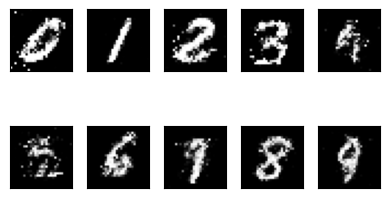

epoch = 52/100, d_loss=0.641, g_loss=0.853                                                                                                                      
epoch = 53/100, d_loss=0.647, g_loss=0.928                                                                                                                      
epoch = 54/100, d_loss=0.701, g_loss=0.881                                                                                                                      
epoch = 55/100, d_loss=0.652, g_loss=0.900                                                                                                                      
epoch = 56/100, d_loss=0.654, g_loss=0.918                                                                                                                      
epoch = 57/100, d_loss=0.609, g_loss=0.881                                                                                                                      
epoch = 58/100, d_loss=0.649, g_lo

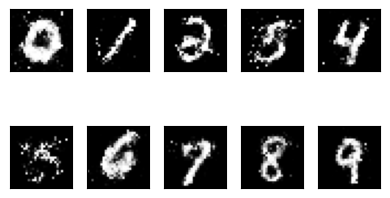

epoch = 62/100, d_loss=0.644, g_loss=0.916                                                                                                                      
epoch = 63/100, d_loss=0.657, g_loss=0.898                                                                                                                      
epoch = 64/100, d_loss=0.629, g_loss=0.978                                                                                                                      
epoch = 65/100, d_loss=0.680, g_loss=0.869                                                                                                                      
epoch = 66/100, d_loss=0.671, g_loss=0.964                                                                                                                      
epoch = 67/100, d_loss=0.611, g_loss=0.979                                                                                                                      
epoch = 68/100, d_loss=0.657, g_lo

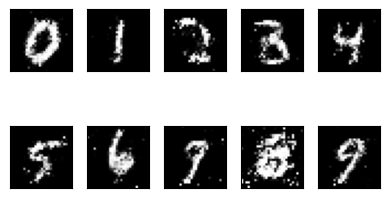

epoch = 72/100, d_loss=0.669, g_loss=0.911                                                                                                                      
epoch = 73/100, d_loss=0.652, g_loss=0.902                                                                                                                      
epoch = 74/100, d_loss=0.646, g_loss=0.885                                                                                                                      
epoch = 75/100, d_loss=0.663, g_loss=0.895                                                                                                                      
epoch = 76/100, d_loss=0.656, g_loss=0.899                                                                                                                      
epoch = 77/100, d_loss=0.658, g_loss=0.926                                                                                                                      
epoch = 78/100, d_loss=0.655, g_lo

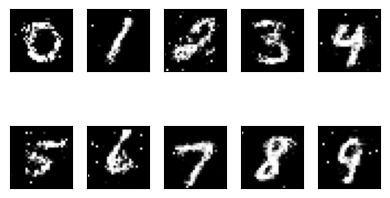

epoch = 82/100, d_loss=0.673, g_loss=0.877                                                                                                                      
epoch = 83/100, d_loss=0.631, g_loss=0.949                                                                                                                      
epoch = 84/100, d_loss=0.646, g_loss=0.954                                                                                                                      
epoch = 85/100, d_loss=0.639, g_loss=0.906                                                                                                                      
epoch = 86/100, d_loss=0.664, g_loss=0.919                                                                                                                      
epoch = 87/100, d_loss=0.639, g_loss=0.856                                                                                                                      
epoch = 88/100, d_loss=0.647, g_lo

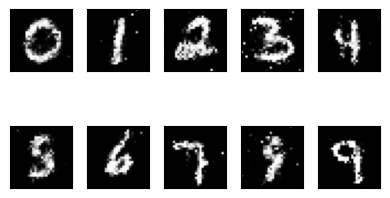

epoch = 92/100, d_loss=0.678, g_loss=0.893                                                                                                                      
epoch = 93/100, d_loss=0.665, g_loss=0.926                                                                                                                      
epoch = 94/100, d_loss=0.624, g_loss=0.891                                                                                                                      
epoch = 95/100, d_loss=0.648, g_loss=0.878                                                                                                                      
epoch = 96/100, d_loss=0.656, g_loss=0.924                                                                                                                      
epoch = 97/100, d_loss=0.619, g_loss=0.920                                                                                                                      
epoch = 98/100, d_loss=0.634, g_lo

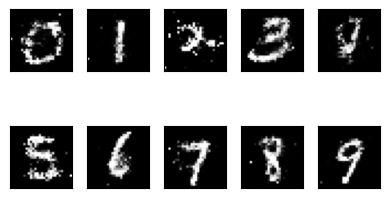

In [17]:
epochs = 100
batch_size = 64
smooth = 0.1

real = tf.ones(shape=(batch_size, 1))
fake = tf.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = X_train[i * batch_size : (i + 1) * batch_size]
        real_labels = y_train[i * batch_size : (i + 1) * batch_size].reshape(
            -1, 1
        )

        d_loss_real = discriminator.train_on_batch(
            x=[X_batch, real_labels], y=real * (1 - smooth)
        )

        # Fake Samples
        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])

        d_loss_fake = discriminator.train_on_batch(
            x=[X_fake, random_labels], y=fake
        )

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                d_g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])

    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], d_g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10
        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        labels = np.arange(0, 10).reshape(-1, 1)

        x_fake = generator.predict([z, labels])

        fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap="gray")
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()


### 5. Evaluate model

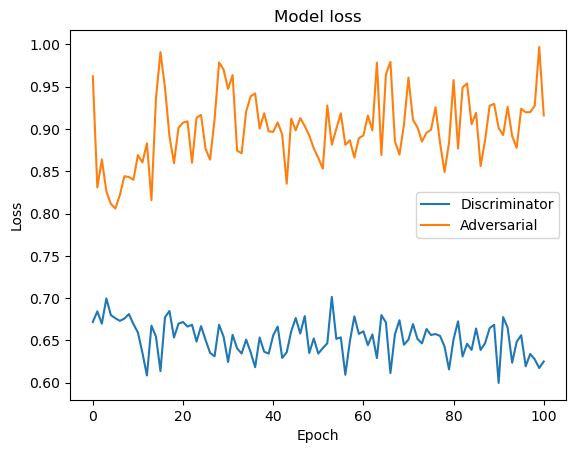

In [18]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()
